In [64]:
import sys
import time
import itertools
import random
import pickle
import os
from PIL import Image

import numpy as np
!pip install matplotlib
import matplotlib.pyplot as plot
%matplotlib inline
!pip install opencv-python
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPool2D,Concatenate,Lambda,Flatten,Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.models import Model

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

In [65]:
import zipfile
with zipfile.ZipFile('/content/data/BHSig260.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

In [66]:
dataset_path1 = "/content/data/BHSig260/Hindi/"
dataset_path2 = "/content/data/BHSig260/Bengali/"
# dataset_path3 = "./dataset/English/"
dataset_all = {}
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
SIZE = 150
DIM = 64
initial_learning_rate = 0.0008
batch_size = 8
epoch = 4

In [67]:
def imageResize(img):
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT)) 
    img = img / 255
    return img

In [68]:
def getDataset(data, path):
    temp_list = []
    for x in range(0, len(data)):
        i = data[x]
        img = np.asarray(Image.open(path + i))
        img = imageResize(img)
        img = img.reshape((IMAGE_WIDTH, IMAGE_HEIGHT, 1))
        temp_list.append(i)
        dataset_all[i] = img
    return temp_list

In [69]:
def getHindiBengali(path, typ):
    original = []
    forged = []
    with open(path + 'list.forgery') as f:
        Fdata = f.read().split("\n")
        Fdata = Fdata[0:-1]
    with open(path + 'list.genuine') as f:
        Odata = f.read().split("\n")
        Odata = Odata[0:-1]
    with open(path + typ + '_pairs.txt') as f:
        pairs = f.read().split("\n")
        pairs = pairs[0:-1]
    print("Getting Original Data...")
    original = getDataset(Odata, path)
    print("Getting Forged Data...")
    forged = getDataset(Fdata, path)
    return original, forged

In [70]:
def makeHindiBengaliPairs(original, forged, typ):
    x1, x2, y = [], [], []
    rng = 0
    if (typ == "Hindi"):
        rng = 160
    if (typ == "Bengali"):
        rng = 100
    for i in range(0, rng):
        f_start = i * 30
        o_start = i * 24
        for j in range(o_start, o_start + 24):
            for k in range(j + 1, o_start + 24):
                x1.append(original[j])
                x2.append(original[k])
                y.append(1)
            for k in range(f_start, f_start + 30):
                x1.append(original[j])
                x2.append(forged[k])
                y.append(0)
    return x1, x2, y

In [71]:
def vis_data(original_train, forged_train, typ):
    loc = ""
    if (typ == "Hindi"):
        loc = dataset_path1
    if (typ == "Bengali"):
        loc = dataset_path2
    figure, (axis1, axis2) = plot.subplots(1, 2, figsize = (10, 10))
    x = np.random.randint(len(original_train))
    original_image_name = random.sample(original_train[x], 1)
    forged_image_name = random.sample(forged_train[x], 1)
    original_image = cv2.imread(loc + original_train[x], 0)
    forged_image = plot.imread(loc + forged_train[x], 0)
    original_image = cv2.resize(original_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    forged_image = cv2.resize(forged_image, (IMAGE_WIDTH, IMAGE_HEIGHT))

    axis1.imshow(original_image, cmap = 'gray')
    axis2.imshow(forged_image, cmap = 'gray')

    axis1.set_title('Original Copy')
    axis1.axis('off')
    axis2.set_title('Forged Copy')
    axis2.axis('off')

In [72]:
H_original, H_forged = getHindiBengali(dataset_path1, "Hindi")

Getting Original Data...
Getting Forged Data...


In [73]:
X1_H, X2_H, y_H = makeHindiBengaliPairs(H_original, H_forged, "Hindi")

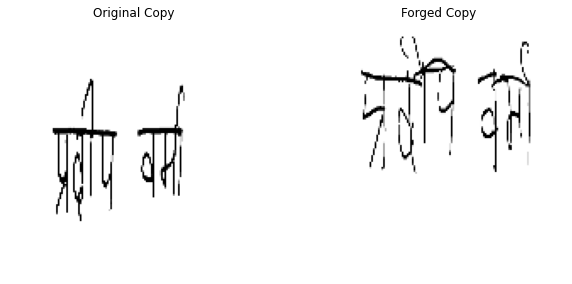

In [74]:
vis_data(X1_H, X2_H, "Hindi")

In [75]:
B_original, B_forged = getHindiBengali(dataset_path2, "Bengali")

Getting Original Data...
Getting Forged Data...


In [76]:
X1_B, X2_B, y_B = makeHindiBengaliPairs(B_original, B_forged, "Bengali")

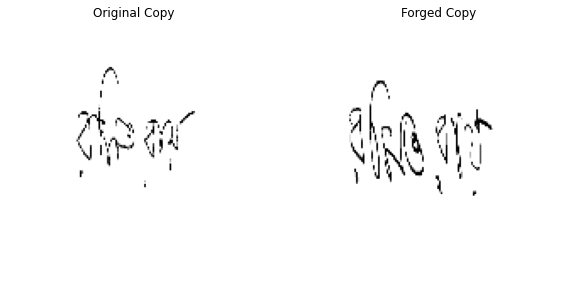

In [77]:
vis_data(X1_B, X2_B, "Bengali")

In [78]:
X1 = np.concatenate([X1_H, X1_B])
X2 = np.concatenate([X2_H, X2_B])
Y  = np.concatenate([y_H, y_B])
print(len(X1), len(X2), len(Y))

258960 258960 258960


In [79]:
ipos = list(zip(X1, X2, Y))
random.shuffle(ipos)
X1, X2, Y = zip(*ipos)
Y = tf.cast(Y, tf.float32)

In [52]:
limit = len(X1) - int(0.30 * len(X1))
X1_train, X2_train, Y_train, X1_val, X2_val, Y_val, X1_test, X2_test, Y_test = X1[0:limit], X2[0:limit], Y[0:limit], X1[limit:limit+30000], X2[limit:limit+30000], Y[limit:limit+30000],X1[limit+30000:], X2[limit+30000:], Y[limit+30000:]

In [80]:
def generate_batch(x1, x2, startpoint, batch_size):
    first = np.zeros((batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
    second = np.zeros((batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
    counter = 0
    for i in range(startpoint, startpoint + batch_size):
        first[counter] = dataset_all[x1[i]]
        second[counter] = dataset_all[x2[i]]
        counter += 1
    return first, second

In [81]:
def return_images(names_list):
    length = len(names_list)
    images = np.zeros((length, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
    for i in range(0, length):
        images[i] = dataset_all[names_list[i]]
    return images

In [82]:
def generate_data(batch_size, x1, x2, y):
    y_len = y.shape[0]
    counter = 0
    while True:
        if counter >= y_len:
            counter = 0
        a, b = generate_batch(x1, x2, counter, batch_size)
        y1 = y[counter : counter + batch_size]
        counter += batch_size
        yield [a,b],y1

In [83]:
def prep_model(dim):
    main_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(dim, (3,3), input_shape=(SIZE, SIZE,1),name='Layer1'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
    
  tf.keras.layers.Conv2D(dim * 2, (3,3),name='Layer2'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.1),
    
  tf.keras.layers.Conv2D(dim * 4, (3,3),name='Layer3'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(4, 4),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(dim * 8, (3,3),name='Layer4'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(4, 4),
  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Conv2D(dim * 8, (1,1),name='Layer5'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Flatten(),
],name='main_model')
    print(main_model.summary())
    return main_model

In [84]:
def calculate_test_accuracy(Y, preds, thres):
    preds_list = []
    for i in preds:
        if i[0] < 0.35:
            preds_list.append(0)
        else:
            preds_list.append(1)
            
    x = 0
    for i in range(0, len(Y)):
        if Y_test[i] == preds_list[i]:
            x = x + 1
    return x * 100 / len(preds_list)

In [85]:
main_model = prep_model(DIM)

Model: "main_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 148, 148, 64)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 148, 148, 64)      592       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
Layer2 (Conv2D)              (None, 72, 72, 128)       73856     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 72, 72, 128)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 72, 72, 128)       2

In [86]:
input_1 = tf.keras.layers.Input(shape = (SIZE, SIZE, 1), name = 'input1')
input_2 = tf.keras.layers.Input(shape = (SIZE, SIZE, 1), name = 'input2')

embd_one = main_model(input_1)
embd_two = main_model(input_2)

out = tf.keras.layers.concatenate([embd_one, embd_two], axis = 1)
out = tf.keras.layers.Dense(DIM * 8, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.1))(out)
out = tf.keras.layers.Dense(DIM, activation='relu')(out)

out = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Output')(out)

model = tf.keras.models.Model([input_1, input_2], out)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
main_model (Sequential)         (None, 512)          1813520     input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1024)         0           main_model[0][0]           

In [87]:
lrate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = 5, 
    decay_rate = 0.96,
    staircase = True
) 
optimizer = tf.keras.optimizers.RMSprop(learning_rate = lrate_schedule)

In [88]:
rms = tf.keras.optimizers.RMSprop(lr = 1e-4, rho = 0.9, epsilon = 1e-08)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [89]:
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/Weights/point-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [91]:
model.fit(
    generate_data(batch_size, X1_train, X2_train, Y_train),
    epochs = 1,
    steps_per_epoch = Y_train.shape[0] // batch_size,
    validation_data = generate_data(batch_size, X1_val, X2_val, Y_val),
    validation_steps = Y_val.shape[0] // batch_size,
    verbose=1,
    callbacks = callbacks
)

22659/22659 [==============================] - 620s 27ms/step - loss: 0.5991 - accuracy: 0.7231 - val_loss: 0.6000 - val_accuracy: 0.7220

Epoch 00001: saving model to /content/Weights/point-001.h5


In [92]:
training_accuracy = model.evaluate(generate_data(batch_size, X1_train, X2_train, Y_train), batch_size = batch_size, steps = Y_val.shape[0] // batch_size)
print("Training Set Accuracy is : ", training_accuracy[1] * 100)

3750/3750 [==============================] - 37s 10ms/step - loss: 0.5987 - accuracy: 0.7232
Training Set Accuracy is :  72.32000231742859


In [ ]:
validation_accuracy = model.evaluate(generate_data(batch_size, X1_val, X2_val, Y_val), batch_size = batch_size, steps = Y_val.shape[0])
print("Validation Set Accuracy is : ", validation_accuracy[1] * 100)

 1348/30000 [>.............................] - ETA: 4:42 - loss: 0.5945 - accuracy: 0.7282

In [2]:
testing_predictions = model.predict([return_images(X1_test), return_images(X2_test)])

NameError: ignored

# New Section

In [1]:
print("Test Set Accuracy is : ", calculate_test_accuracy(Y_test, testing_predictions, np.mean(testing_predictions)))

NameError: ignored